In [1]:
import numpy as np
import networkx as nx
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go
import plotly.express as px
from pathlib import Path
import json
from mesh_utils import load_and_process_mesh, orient_centroid
import matplotlib.pyplot as plt
import igl
import scipy.sparse as sp

### Load Meshes

In [2]:
base_dir = Path("/Users/schimmenti/Desktop/DresdenProjects/wingsurface/final_meshes/wildtype/")
#base_dir = Path("meshes/")
json_file_with_infos = base_dir.joinpath("mesh_infos.json")
mesh_infos_dict = json.load(open(json_file_with_infos))
mesh_infos_dict = { identifier : info for identifier, info in sorted(mesh_infos_dict.items())}

In [4]:
def load_mesh(mesh_info):
    scale = mesh_info['scale'] if 'scale' in mesh_info else 1.0
    flip0 = mesh_info['flip0'] if 'flip0' in mesh_info else False
    flip1 = mesh_info['flip1'] if 'flip1' in mesh_info else False
    flip2 = mesh_info['flip2'] if 'flip2' in mesh_info else False
    vertices, triangles  = load_and_process_mesh(base_dir.joinpath(mesh_info['filename']), scale=scale, flip0=flip0, flip1=flip1, flip2=flip2, return_as_open3d_mesh=False)
    vertex_normals = igl.per_vertex_normals(vertices, triangles)
    triangles, vertex_normals = orient_centroid(vertices, triangles, vertex_normals)
    #if(loaded_mesh.is_vertex_manifold()==False):
    #    print(f"Mesh {mesh_identifier} is not vertex manifold!")
    #if(loaded_mesh.is_edge_manifold()==False):
    #    print(f"Mesh {mesh_identifier} is not edge manifold!")
    #vertices, triangles = np.asarray(loaded_mesh.vertices), np.asarray(loaded_mesh.triangles)
    adjList = igl.adjacency_list(triangles)
    adjGraph = nx.from_dict_of_lists({ i : list(adjList[i])  for i in range(len(adjList))})
    cotmatrix = igl.cotmatrix(vertices, triangles)
    massmatrix = igl.massmatrix(vertices, triangles, igl.MASSMATRIX_TYPE_VORONOI)
    
    laplacian = sp.linalg.inv(massmatrix) @ cotmatrix
    mean_curvature = np.sum((laplacian @ vertices)*vertex_normals, axis=1)
    pc_res = igl.principal_curvature(vertices, triangles)[:4]
    mesh_dict = {}
    mesh_dict['vertices'] = vertices
    mesh_dict['triangles'] = triangles
    #mesh_dict['adjList'] = adjList
    mesh_dict['adjGraph'] = adjGraph
    mesh_dict['cotmatrix'] = cotmatrix
    mesh_dict['massmatrix'] = massmatrix
    mesh_dict['laplacian'] = laplacian
    mesh_dict['vertex_normals'] = vertex_normals
    mesh_dict['mean_curvature'] = mean_curvature
    mesh_dict['principal_curvature_1'] = pc_res[2]
    mesh_dict['principal_curvature_2'] = pc_res[3]
    return mesh_dict

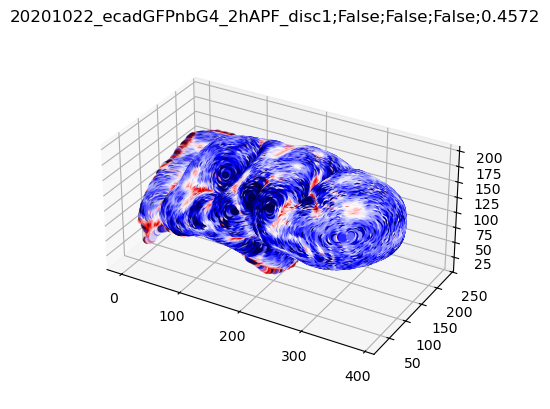

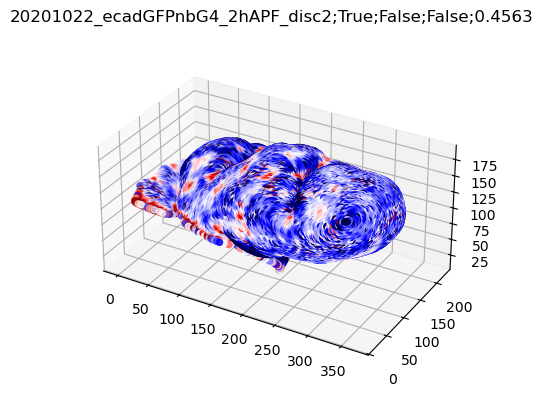

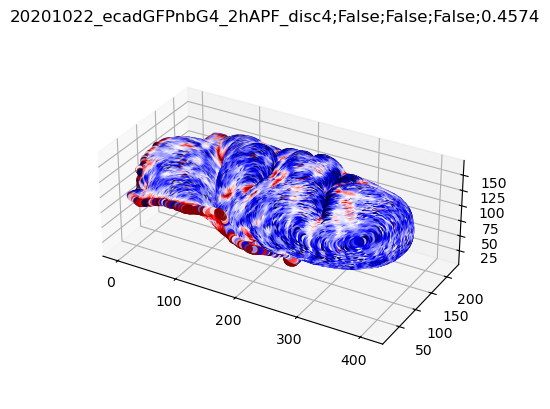

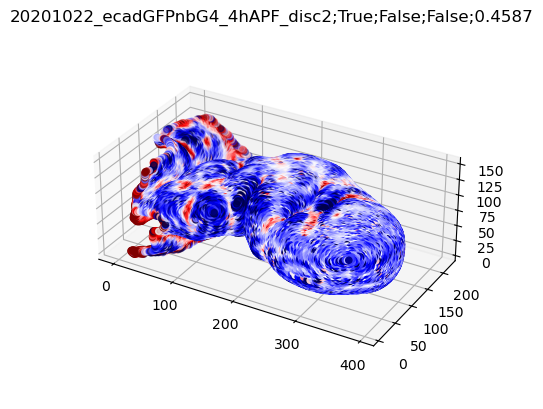

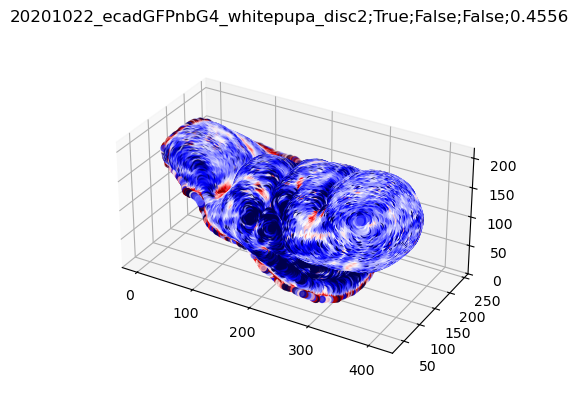

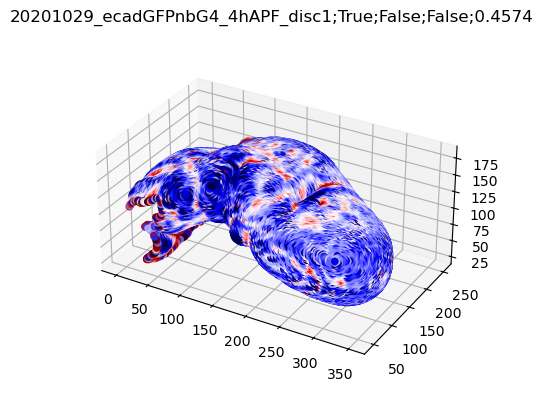

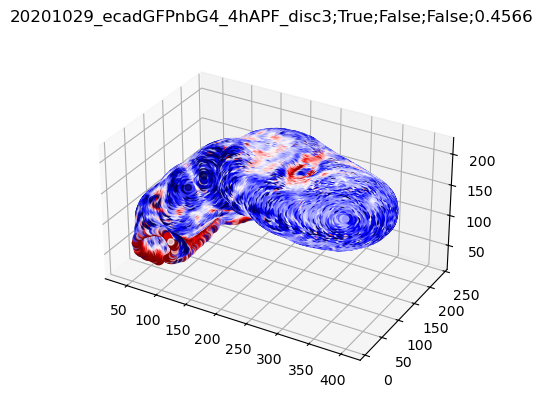

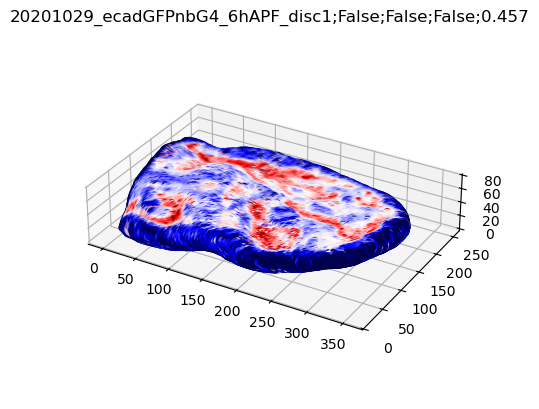

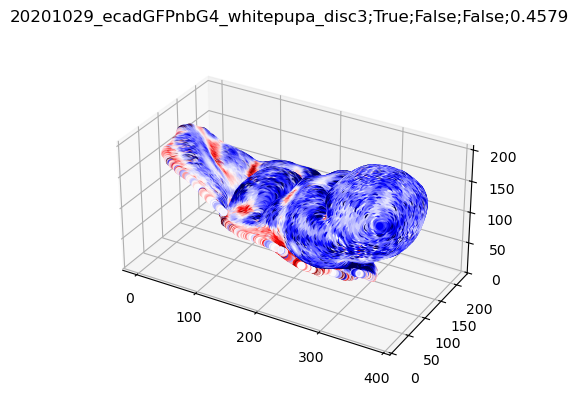

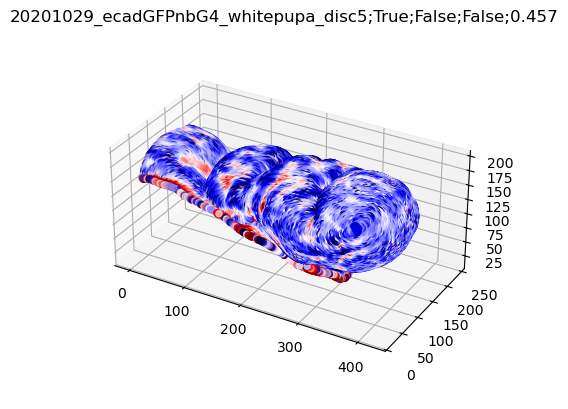

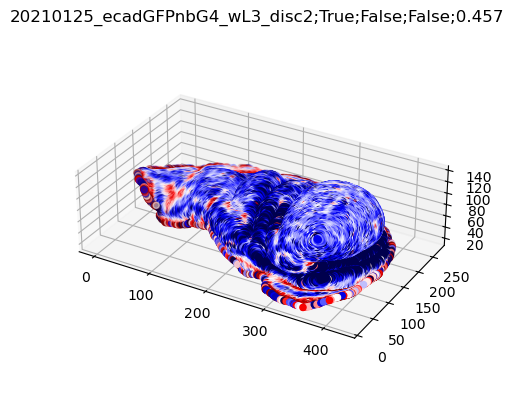

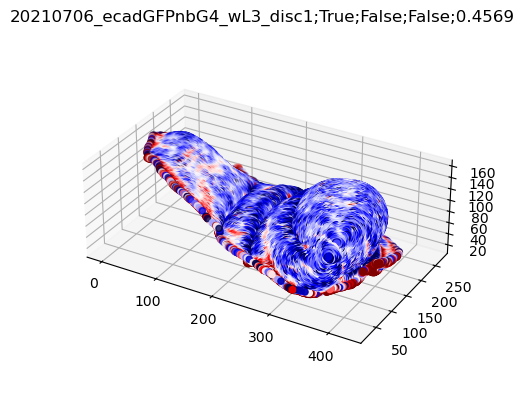

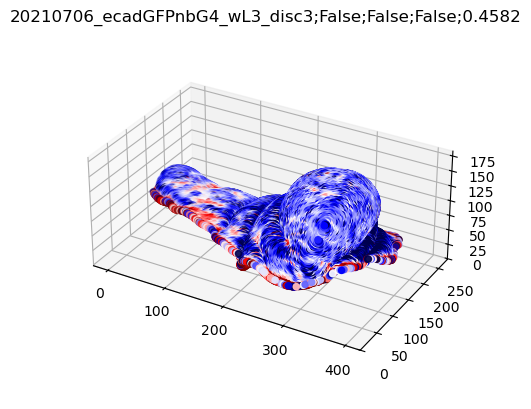

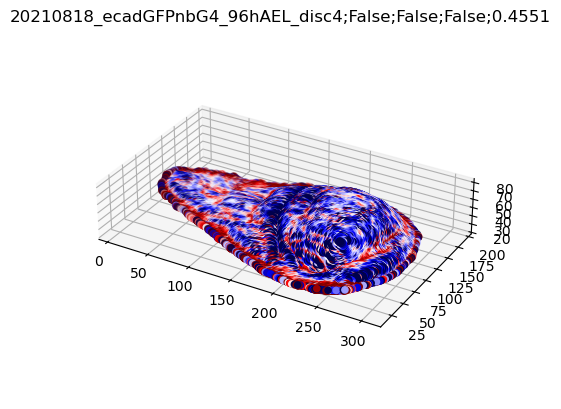

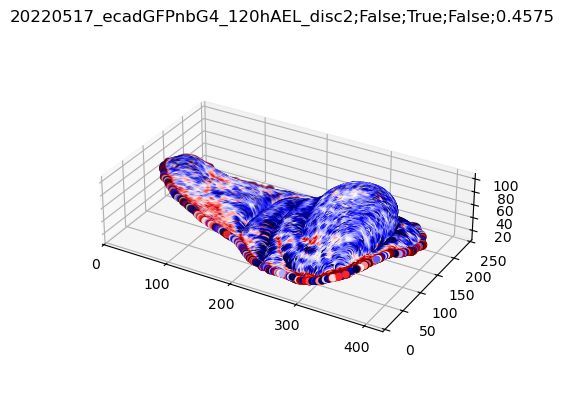

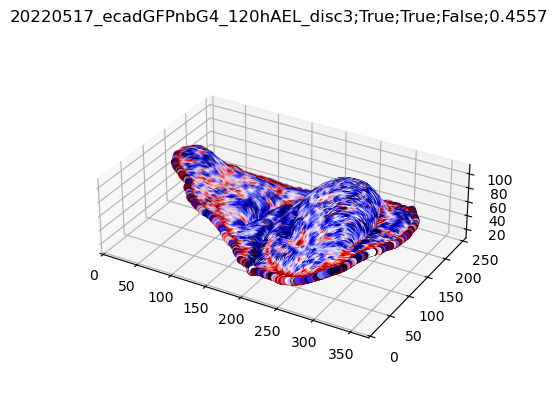

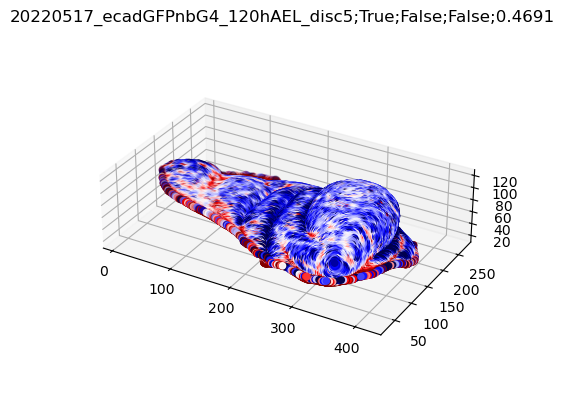

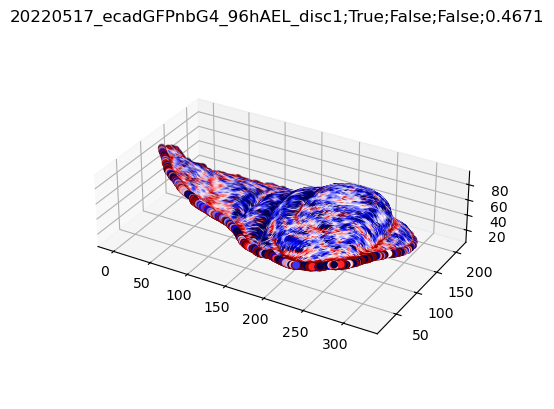

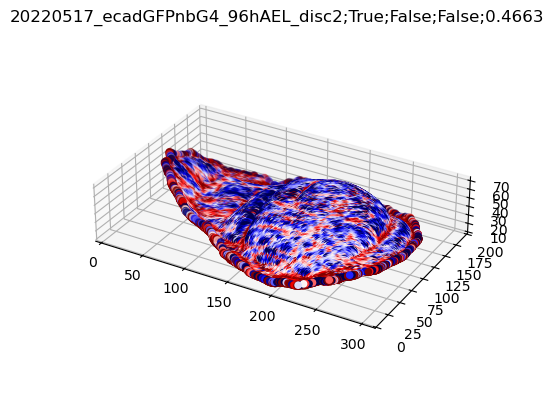

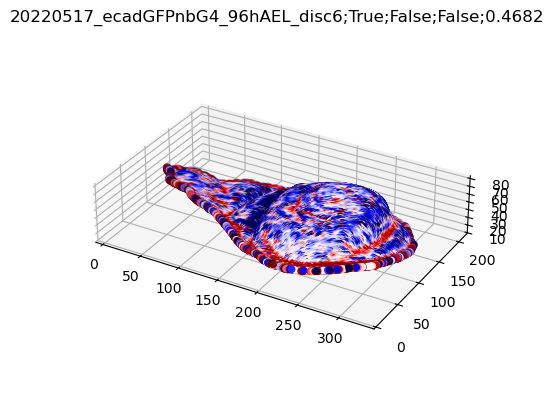

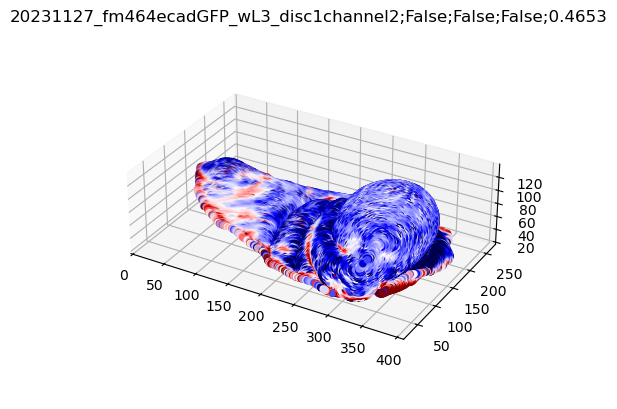

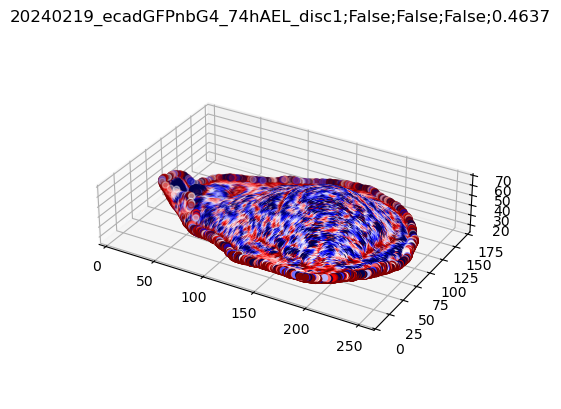

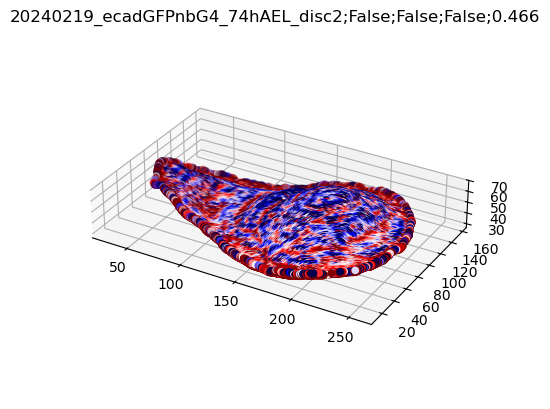

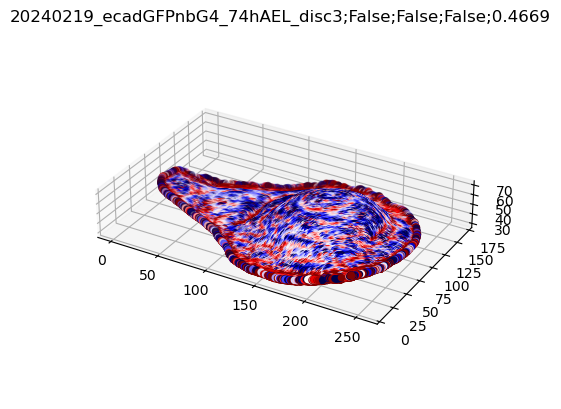

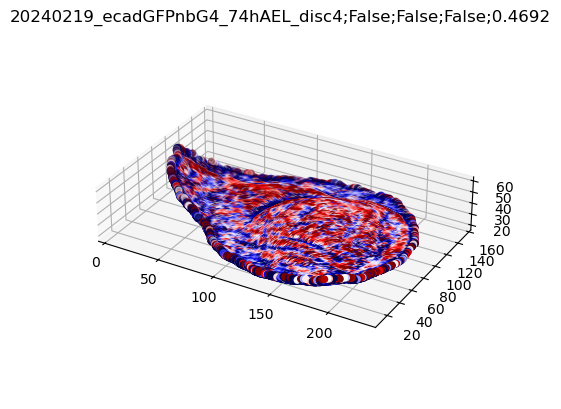

In [8]:
meshes_dict = {}
for mesh_identifier, mesh_info in mesh_infos_dict.items():
    scale = mesh_info['scale'] if 'scale' in mesh_info else 1.0
    flip0 = mesh_info['flip0'] if 'flip0' in mesh_info else False
    flip1 = mesh_info['flip1'] if 'flip1' in mesh_info else False
    flip2 = mesh_info['flip2'] if 'flip2' in mesh_info else False
    mesh_dict = load_mesh(mesh_info)
    meshes_dict[mesh_identifier] = mesh_dict
    vertices = mesh_dict['vertices']
    triangles = mesh_dict['triangles']
    normals = mesh_dict['vertex_normals']
    mean_curvature = mesh_dict['mean_curvature']
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(vertices[:, 1], vertices[:, 2], vertices[:, 0], c=mean_curvature, cmap='seismic', vmin=-0.1, vmax=0.1)
    #ax.quiver(vertices[::50, 1], vertices[::50, 2], vertices[::50, 0], normals[::50, 1], normals[::50, 2], normals[::50, 0], length=20, color='black')
    ax.set_title(';'.join([mesh_identifier, str(flip0), str(flip1), str(flip2), str(scale)]))
    ax.set_aspect('equal')
    plt.show()

### Annotate

In [ ]:
file_keys = list(mesh_infos_dict.keys())
exported_params = {}

In [ ]:
def inflate_component(graph : nx.Graph, nodes, dist : int):
    if dist <= 0:
        return set(nodes)
    inflated = set(nodes)
    frontier = set(nodes)
    for _ in range(dist):
        next_frontier = set()
        for node in frontier:
            next_frontier.update(graph.neighbors(node))
        next_frontier -= inflated
        inflated.update(next_frontier)
        frontier = next_frontier
        if not frontier:
            break
    return inflated
class MeshSegmentation:
    def __init__(self, vertices, triangles, adjGraph, mean_curvature, principal_curvature_1, principal_curvature_2):
        self.vertices = vertices
        self.triangles = triangles
        self.adjGraph = adjGraph
        self.mean_curvature = mean_curvature
        self.principal_curvature_1 = principal_curvature_1
        self.principal_curvature_2 = principal_curvature_2
        self.principal_curvature_2_percentiles = np.percentile(self.principal_curvature_2, np.arange(0, 101, 1))
        self.num_vertices = len(vertices)
        self.H_min_mask = np.ones(self.num_vertices, dtype=bool)
        self.H_max_mask = np.ones(self.num_vertices, dtype=bool)
        self.H_min = np.inf
        self.H_max = -np.inf
        self.pc2_mask = np.ones(self.num_vertices, dtype=bool)
        self.pc2_percentile = 0
        self.inflate_dist = 0
        self.clusters = []
        self.inflated_clusters = []
        self.num_clusters = 0
        
    
    def update(self, H_min : float, H_max : float, pc2_percentile : float, inflate_dist : int):
        needs_update = False
        if(H_min is not None and H_min!=self.H_min):
            needs_update = True
            self.H_min = H_min
            self.H_min_mask = self.mean_curvature >= self.H_min
        elif(H_min is None):
            self.H_min_mask = np.ones(self.num_vertices, dtype=bool)
        if(H_max is not None and H_max!=self.H_max):
            needs_update = True
            self.H_max = H_max
            self.H_max_mask = self.mean_curvature <= self.H_max
        elif(H_max is None):
            self.H_max_mask = np.ones(self.num_vertices, dtype=bool)
        if(pc2_percentile is not None):
            int_pc2_percentile = min(max(int(pc2_percentile), 0),100)
            if(int_pc2_percentile!=self.pc2_percentile):
                needs_update = True
                self.pc2_percentile = int_pc2_percentile
                self.pc2_mask = self.principal_curvature_2 < self.principal_curvature_2_percentiles[self.pc2_percentile]
        elif(pc2_percentile is None):
            self.pc2_mask = np.ones(self.num_vertices, dtype=bool)
        if(inflate_dist is not None):
            if(inflate_dist != self.inflate_dist):
                needs_update = True
                self.inflate_dist = inflate_dist            
        if(needs_update):
            mask = self.H_min_mask & self.H_max_mask & self.pc2_mask
            subgraph = self.adjGraph.subgraph(np.where(mask)[0])
            found_clusters = sorted(list(nx.connected_components(subgraph)), key=len, reverse=True)
            self.clusters.clear()
            self.inflated_clusters.clear()
            self.num_clusters = len(found_clusters)
            self.clusters = [np.array(list(cluster)) for cluster in found_clusters]
            for i, cluster in enumerate(found_clusters):
                inflated = inflate_component(self.adjGraph, cluster, self.inflate_dist)
                self.inflated_clusters.append(np.array(list(inflated)))
    def import_params(self, import_dict):
        self.H_min = import_dict['H_min']
        self.H_max = import_dict['H_max']
        self.pc2_percentile = import_dict['pc2_percentile']
        self.inflate_dist = import_dict['inflate_dist']
        self.update(self.H_min, self.H_max, self.pc2_percentile, self.inflate_dist)
    def export_params(self):
        export_dict = {}
        export_dict['clusters'] = [ cluster.tolist() for cluster in self.clusters]
        export_dict['inflated_clusters'] = [ cluster.tolist() for cluster in self.inflated_clusters]
        export_dict['H_min'] = self.H_min
        export_dict['H_max'] = self.H_max
        export_dict['pc2_percentile'] = self.pc2_percentile
        export_dict['inflate_dist'] = self.inflate_dist
        return export_dict

In [ ]:
mesh_segmentation = None
current_sample_id = None

sample_id_widget = widgets.Dropdown(options=file_keys, description='Sample')
use_pc2_widget = widgets.Checkbox(value=True, description='Use k2')
pc2_percentile_widget = widgets.IntSlider(value=20, min=0, max=100, step=1, description='k2 perc.')
use_mean_curv_widget = widgets.Checkbox(value=True, description='Use H')
mean_curv_min_widget = widgets.FloatText(value=0.1, description='H min')
mean_curv_max_widget = widgets.FloatText(value=3.0, description='H max')
num_comps_widget = widgets.IntText(value=10, description='Num comps', disabled=True)
inflate_dist_widget = widgets.IntText(value=0, description='Inflate')

fig = go.FigureWidget()
fig.update_layout(
    title="",
    width=800, height=700,
    scene=dict(
        xaxis_title='y', yaxis_title='z', zaxis_title='x',
        aspectmode='data',
        uirevision="keep"  # preserve camera/zoom
    ),
    margin=dict(l=0, r=0, t=60, b=0),
    legend=dict(itemsizing='constant')
)
palette = px.colors.qualitative.T10



# --- Helper: restore params/annotations for a sample (if we have them) ---
def _apply_saved_params_for_sample(sid):
    return

# --- Main recompute/draw (reads current widget values) ---
def update_plot(*_):
    global mesh_segmentation, current_sample_id
    sample_id      = sample_id_widget.value
    use_pc2        = use_pc2_widget.value
    pc2_percentile = pc2_percentile_widget.value
    use_mean_curv  = use_mean_curv_widget.value
    mean_curv_min  = mean_curv_min_widget.value
    mean_curv_max  = mean_curv_max_widget.value
    inflate_dist   = inflate_dist_widget.value
    num_comps = num_comps_widget.value

    # we need to load the mesh if it's a new sample
    redraw_needed = False
    if current_sample_id is None or sample_id != current_sample_id:
        if(mesh_segmentation is not None):
            # export params for previous sample
            exported_params[current_sample_id] = mesh_segmentation.export_params()
        #mesh_dict = load_mesh(mesh_infos_dict[sample_id])
        mesh_dict = meshes_dict[sample_id]
        vertices = mesh_dict['vertices']
        triangles = mesh_dict['triangles']
        adjGraph = mesh_dict['adjGraph']
        mean_curvature = mesh_dict['mean_curvature']
        principal_curvature_1 = mesh_dict['principal_curvature_1']
        principal_curvature_2 = mesh_dict['principal_curvature_2']
        mesh_segmentation = MeshSegmentation(vertices, triangles, adjGraph, mean_curvature, principal_curvature_1, principal_curvature_2)
        
        current_sample_id = sample_id
        redraw_needed = True
    else:
        vertices = mesh_segmentation.vertices
    
    mesh_segmentation.update(
            H_min = mean_curv_min if use_mean_curv else None,
            H_max = mean_curv_max if use_mean_curv else None,
            pc2_percentile = pc2_percentile if use_pc2 else None,
            inflate_dist = inflate_dist
        )
    
    

    # Draw: keep mesh persistent; rebuild only clusters/rings
    with fig.batch_update():
        if redraw_needed:
            # rebuild background mesh once for this sample
            fig.data = []  # clear everything
            fig.add_trace(go.Scatter3d(
                x=vertices[:, 1], y=vertices[:, 2], z=vertices[:, 0],
                mode='markers',
                marker=dict(size=1, opacity=0.5, color='gray'),
                name='Mesh'
            ))
        else:
            # keep only the mesh trace; drop old clusters/rings
            fig.data = fig.data[:1]

        for i, comp in enumerate(mesh_segmentation.clusters[:num_comps]):
            inflated_comp = mesh_segmentation.inflated_clusters[i] 
            color = palette[i % len(palette)]
            # core
            fig.add_trace(go.Scatter3d(
                x=vertices[comp, 1], y=vertices[comp, 2], z=vertices[comp, 0],
                mode='markers',
                marker=dict(size=4, color=color, symbol='circle'),
                name=f'Cluster {i} ({len(comp)})',
                legendgroup=f'c{i}',
                showlegend=True
            ))
            enlarged_only = np.setdiff1d(inflated_comp, comp)
            if enlarged_only.size > 0:
                fig.add_trace(go.Scatter3d(
                    x=vertices[enlarged_only, 1], y=vertices[enlarged_only, 2], z=vertices[enlarged_only, 0],
                    mode='markers',
                    marker=dict(size=5, symbol='x', color=color),
                    name=f'Ring {i} (+{len(enlarged_only)})',
                    legendgroup=f'c{i}',
                    showlegend=True
                ))
    
        fig.update_layout(
            scene_camera=fig.layout.scene.camera or dict(eye=dict(x=0.0, y=0.0, z=2.5))
        )

# --- Wire observers explicitly (no interactive_output) ---
_suppress = {"v": False}

def _on_any_param_change(change):
    if not _suppress["v"]:
        update_plot()

def _bind_param(w):
    w.observe(_on_any_param_change, names='value')

for w in [
    use_pc2_widget, pc2_percentile_widget, use_mean_curv_widget,
    mean_curv_min_widget, mean_curv_max_widget,
    inflate_dist_widget
]:
    _bind_param(w)

def on_sample_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        sid = change['new']
        # Temporarily suppress reactive updates while restoring widgets
        _suppress["v"] = True
        _apply_saved_params_for_sample(sid)  # restore if available
        _suppress["v"] = False
        update_plot()  # recompute once with restored params

sample_id_widget.observe(on_sample_change, names='value')

# --- UI layout & initial draw ---
ui = widgets.VBox([
    sample_id_widget,
    widgets.HBox([use_pc2_widget, pc2_percentile_widget]),
    widgets.HBox([use_mean_curv_widget, mean_curv_min_widget, mean_curv_max_widget]),
    widgets.HBox([inflate_dist_widget])
])

display(ui, fig)

# If the initial sample has saved params, restore them first
_suppress["v"] = True
_apply_saved_params_for_sample(sample_id_widget.value)
_suppress["v"] = False

update_plot()